In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import scipy as sp
import os
import pickle
from decimal import Decimal
import h5py
import itertools
from collections import OrderedDict
import imp
from tqdm import tqdm

import astropy.constants as C
import astropy.units as u
import astropy as ap

import peters

from matplotlib import gridspec
import matplotlib
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator

cp = sns.color_palette("colorblind", 6)

plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

### Do selection effects on a grid

In [2]:
# do selection function on a grid
import selection_effects
imp.reload(selection_effects)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


<module 'selection_effects' from '/Users/michaelzevin/research/utilities/selection_effects.py'>

In [12]:
import lalsimulation
ifos_O3_single = {"H1":"midhighlatelow"}
ifos_O3_network = {"H1":"midhighlatelow",
            "L1":"midhighlatelow", 
            "V1":"midhighlatelow"}
ifos_design_single = {"H1":"design"}
ifos_design_network = {"H1":"design",
            "L1":"design", 
            "V1":"design"}
%timeit selection_effects.detection_probability([5, 5, 0.1, (0,0,0), (0,0,0)], ifos=ifos_design, Ntrials=1000, f_low=10, \
                                        psd_path="/Users/michaelzevin/research/ligo/PSDs/")

# NOTE: about 200 ms per system, so 5 systems per s

234 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
Nsamp = 20
ms = np.logspace(np.log10(5), np.log10(200), Nsamp)

zs = np.logspace(np.log10(0.01), np.log10(2), Nsamp)
Ms, Zs = np.meshgrid(ms, zs)

100%|██████████| 400/400 [00:32<00:00, 12.35it/s]


Text(0, 0.5, 'z')

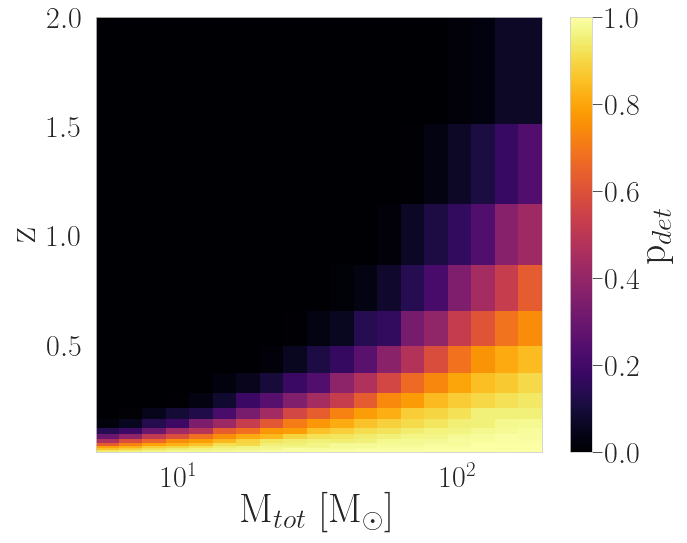

In [15]:
# O3
p_det = []
for idx, (M, Z) in tqdm(enumerate(zip(Ms.flatten(), Zs.flatten())), total=len(Ms.flatten())):
    p_det.append(selection_effects.detection_probability([M/2., M/2., Z, (0,0,0), (0,0,0)], ifos=ifos_design_single, Ntrials=1000, f_low=10, \
                                                        psd_path="/Users/michaelzevin/research/ligo/PSDs/"))
    
fig, ax = plt.subplots(1,1, figsize=(10,8))

p_det = np.reshape(p_det, (Nsamp, Nsamp))
c = ax.pcolormesh(Ms, Zs, np.asarray(p_det), cmap='inferno', vmin=0, vmax=1)

cbar = fig.colorbar(c, ax=ax)
cbar.set_label('p$_{det}$')

ax.set_xscale('log')
ax.set_xlabel('M$_{tot}$ [M$_{\odot}$]')
ax.set_ylabel('z')

100%|██████████| 400/400 [01:15<00:00,  5.31it/s]


Text(0, 0.5, 'z')

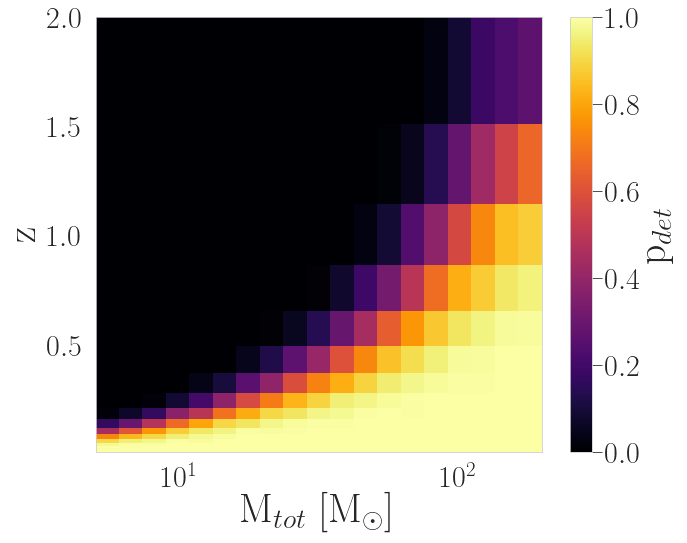

In [16]:
# design
p_det = []
for idx, (M, Z) in tqdm(enumerate(zip(Ms.flatten(), Zs.flatten())), total=len(Ms.flatten())):
    p_det.append(selection_effects.detection_probability([M/2., M/2., Z, (0,0,0), (0,0,0)], ifos=ifos_design_network, Ntrials=1000, f_low=10, \
                                                        psd_path="/Users/michaelzevin/research/ligo/PSDs/"))
    
fig, ax = plt.subplots(1,1, figsize=(10,8))

p_det = np.reshape(p_det, (Nsamp, Nsamp))
c = ax.pcolormesh(Ms, Zs, np.asarray(p_det), cmap='inferno', vmin=0, vmax=1)

cbar = fig.colorbar(c, ax=ax)
cbar.set_label('p$_{det}$')

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('M$_{tot}$ [M$_{\odot}$]')
ax.set_ylabel('z')

### Look at selection effects for the actual models

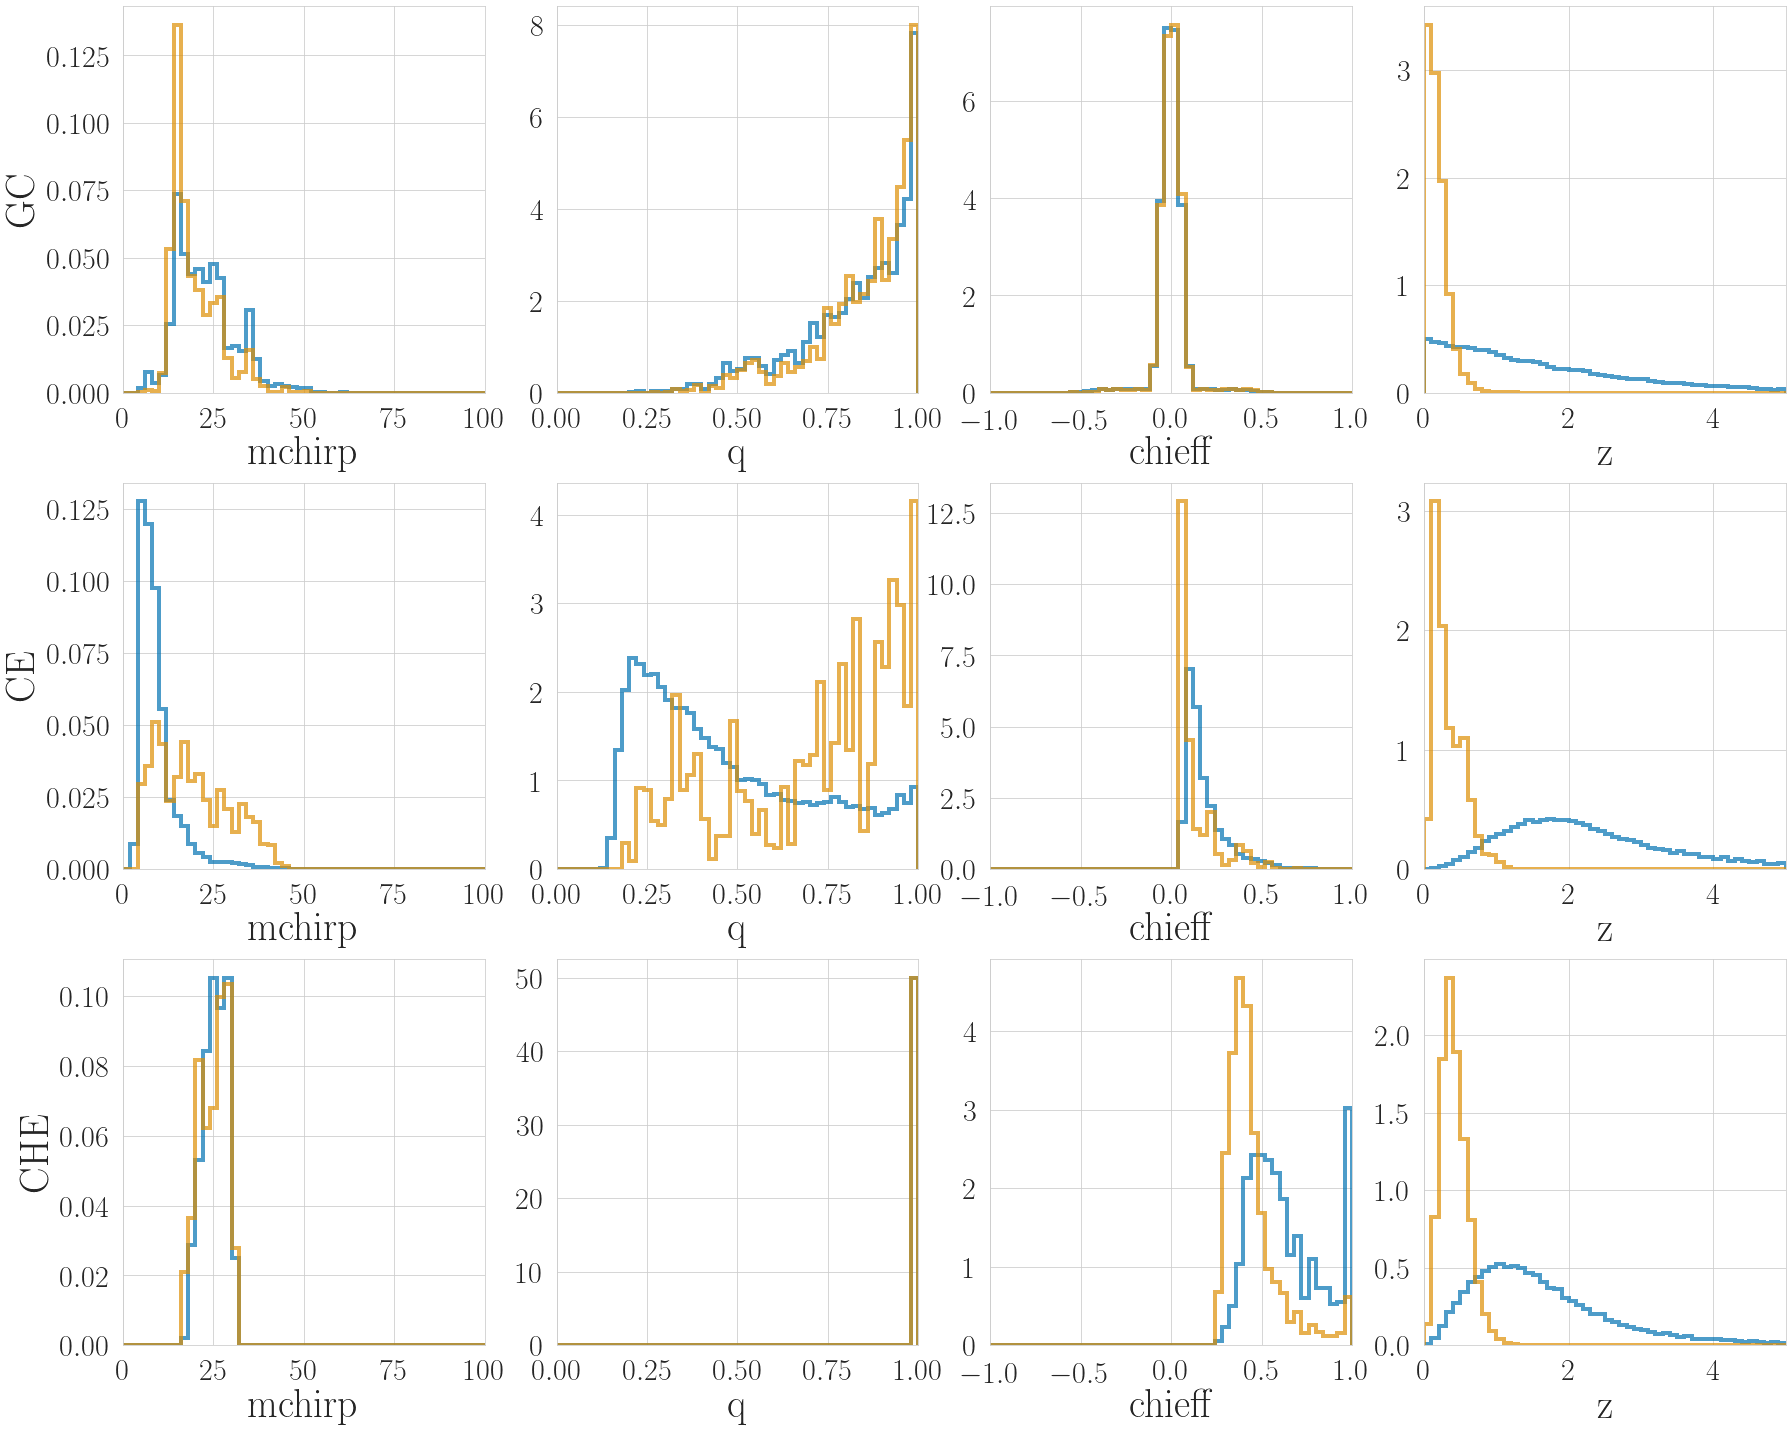

In [18]:
dirpath = '/Users/michaelzevin/research/model_selection/spins/data/detection_weighted/spin_models/'

mdl = 'chi01'
channels = ['GC','CE','CHE']
params = ['mchirp','q','chieff','z']
bounds = [(0,100),(0,1),(-1,1),(0,5)]

weight = 'pdet_O3network'

fig, axs = plt.subplots(3,4, figsize=(25,20))

for cidx, channel in enumerate(channels):
    subaxs = axs[cidx,:]
    subaxs[0].set_ylabel(channel)
    df = pd.read_hdf(dirpath+mdl+'.hdf', key=channel)
    
    for idx, (param,bound,ax) in enumerate(zip(params,bounds,subaxs)):
        ax.set_xlim(bound)
        ax.set_xlabel(param)
        ax.hist(df[param], range=bound, histtype='step', bins=50, alpha=0.7, lw=4, density=True, color=cp[0])
        ax.hist(df[param], range=bound, histtype='step', bins=50, alpha=0.7, lw=4, density=True, weights=df[weight], color=cp[1])

plt.tight_layout()

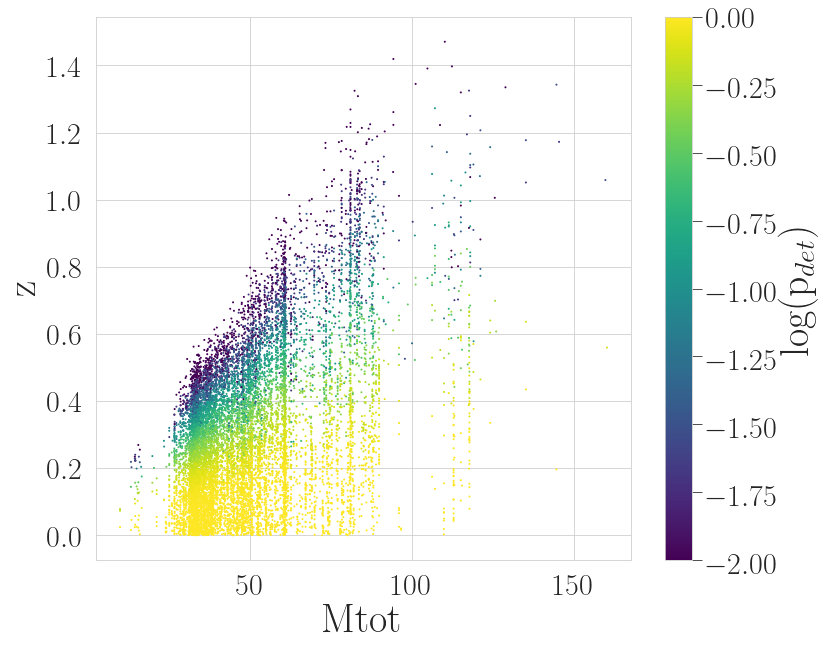

In [38]:
# read in spins data for clusters

dirpath = '/Users/michaelzevin/research/model_selection/spins/data/detection_weighted/spin_models/'

df = pd.read_hdf(dirpath + 'chi00.hdf', key='GC')
df['Mtot'] = df['m1']+df['m2']

fig, axs = plt.subplots(1,1, figsize=(12,10))
x_val = 'Mtot'
y_val = 'z'
pdet = 'pdet_O3network'

pts = axs.scatter(df[x_val], df[y_val], c=np.log10(df[pdet]), cmap='viridis', s=1)
cbar = fig.colorbar(pts, ax=axs)

axs.set_xlabel(x_val)
axs.set_ylabel(y_val)
cbar.set_label(r'log(p$_{det}$)')


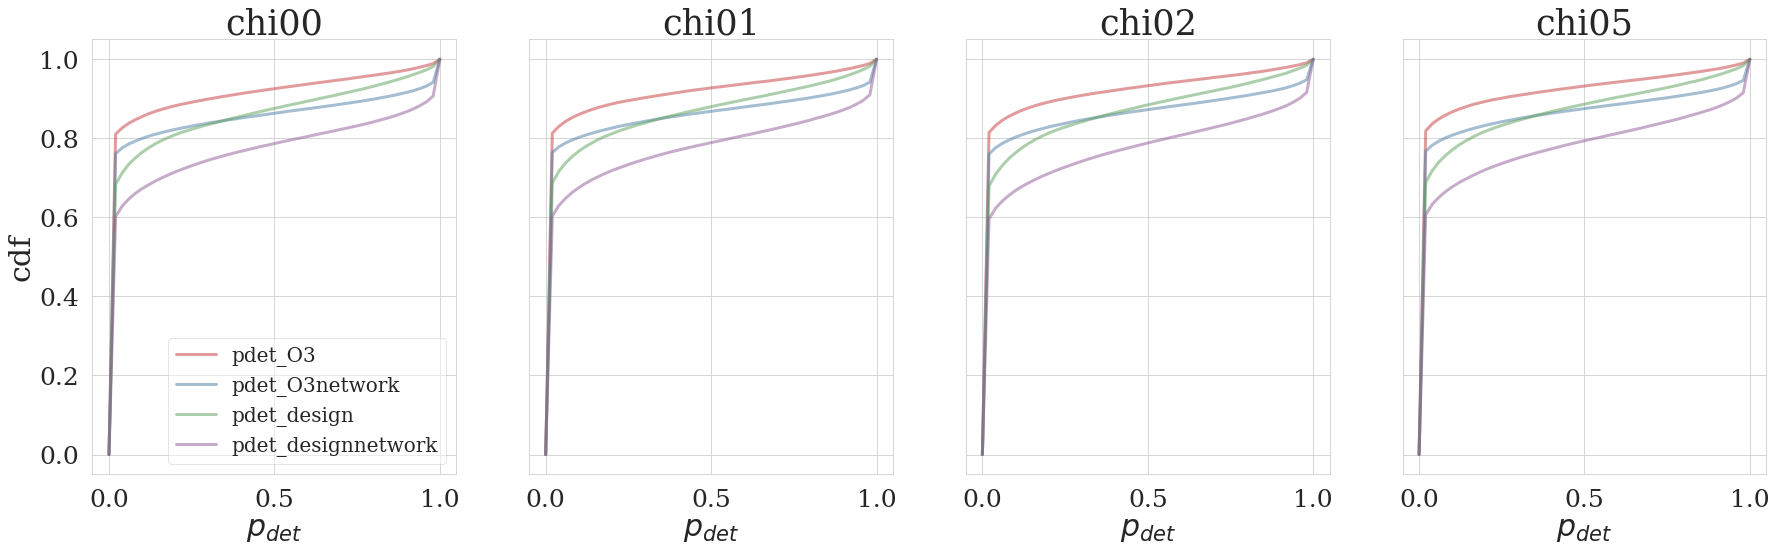

In [5]:
params = {
        # latex
        'text.usetex': False,
        }
plt.rcParams.update(params)

# make cdfs of pdet
pdets = ['pdet_O3','pdet_O3network','pdet_design','pdet_designnetwork']

fig, axs = plt.subplots(1,4, figsize=(30,8))

for idx, sm in enumerate(['chi00','chi01','chi02','chi05']):
    df = data[sm]
    

    for pidx, pdet in enumerate(pdets):
        pdet = pdets[pidx]
        h, bins = np.histogram(df[pdet], bins=50, range=(0,1))
        h = np.insert(h, 0, 0)

        axs[idx].plot(bins, np.cumsum(h)/float(np.sum(h)), alpha=0.5, lw=3, color=colors[pidx], label=pdet)
        
        
    if idx == 0:
        axs[idx].set_ylabel('cdf')
        axs[idx].legend()
    else:
        axs[idx].set_yticklabels([])
        
    axs[idx].set_title(sm)
    axs[idx].set_xlabel('$p_{det}$')


In [19]:
import astropy.units as u
from astropy import cosmology
from astropy.cosmology import z_at_value
cosmo = cosmology.Planck15

gwpath = '/Users/michaelzevin/research/ligo/O2/PE/GWTC-1_sample_release/'
meds = []
stds = []

for gw in os.listdir(gwpath):
    redz = []
    print(gw)
    df = pd.read_hdf(gwpath+gw, key='Overall_posterior')
    dL = np.asarray(df['luminosity_distance_Mpc'])
    for val in tqdm(dL):
        redz.append(z_at_value(cosmo.luminosity_distance, val*u.Mpc))

    redz = np.asarray(redz)
    df['redshift'] = redz
    df.to_hdf(gwpath+gw, key='Overall_posterior')
    meds.append(np.median(redz))
    stds.append(redz.std())
        


  1%|          | 29/5112 [00:00<00:40, 125.70it/s]

GW170729_GWTC-1.hdf5


  0%|          | 37/52252 [00:00<04:47, 181.57it/s]

GW151226_GWTC-1.hdf5


  0%|          | 17/14802 [00:00<01:27, 169.07it/s]

GW170809_GWTC-1.hdf5


  0%|          | 18/24972 [00:00<02:20, 177.24it/s]

GW170104_GWTC-1.hdf5


100%|██████████| 24972/24972 [02:19<00:00, 178.71it/s]


GW170817_GWTC-1.hdf5


KeyError: 'No object named Overall_posterior in the file'

In [12]:
np.mean(stds)

0.046326486513270336